# EECS 598 Lab 4: Domain Randomization and Terrain Generation

![lab4_poster](./media/lab4_poster.png)

This notebook is worth **80 points**. Questions and implementation are marked with relevent `#TODO(student)` markers.

Before starting the assignment, please put your name and UMID in the following format:

Firstname LASTNAME, #00000000 (ex. Drew SCHEFFER #31415926)

**YOUR ANSWER**

Your NAME, #XXXXXXXX

## Setup

In [1]:
import sys, types, importlib

# Create a tiny fake 'imp' module exposing only 'reload'
_imp = types.ModuleType("imp")
_imp.reload = importlib.reload
sys.modules["imp"] = _imp

# load autoreload
%load_ext autoreload
%autoreload 2

In [2]:
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


### Google Colab Setup

Next, we'll run a few fommands to set up the environment on Google Colab. If you are running this notebook locally you can skip this section

Run the following to mount this notebook to your Google Drive. Follow the link and sign into the Google account following the prompts. Use the same Google account that you used to store this notebook. 

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Now update the path below to point to the folder in your Google Drive where you uploaded this notebook. If everything worked correctly you should see the following filenames: [`custom_env.py`, `02_lab.ipynb`]

In [5]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded project 2
# # Example: If you create a 2025FA folder and put all the files under Lab4, then '2025FA/Lab4'
# # GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025FA/Lab4'

# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
# GOOGLE_DRIVE_PATH_LAB3 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# print(os.listdir(GOOGLE_DRIVE_PATH_LAB3))

In [6]:
# from google.colab import files

# import distutils.util
# import os
# import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)



Ensure that everything is installed properly

In [7]:
# import os

# try:
#   print('Checking that the installation succeeded:')
#   import mujoco
#   mujoco.MjModel.from_xml_string('<mujoco/>')
# except Exception as e:
#   raise e from RuntimeError(
#       'Something went wrong during installation. Check the shell output above '
#       'for more information.\n'
#       'If using a hosted Colab runtime, make sure you enable GPU acceleration '
#       'by going to the Runtime menu and selecting "Choose runtime type".')

# print('Installation successful.')

# # Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
# xla_flags = os.environ.get('XLA_FLAGS', '')
# xla_flags += ' --xla_gpu_triton_gemm_any=True'
# os.environ['XLA_FLAGS'] = xla_flags

## Mujoco Setup & Imports

In [8]:
# !pip install mujoco
# !pip install mujoco_mjx
# !pip install brax
# !pip install noise

In [9]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

import cv2

## Randomizing Model Properties in Mujoco Playground 

We might want to include randomization over certain `mjModel` parameters while training different policies. In MJX, we can easily create a **batch** of environments with randomized values populated in `mjx.Model`. Below, you will impliment a simple function that randomizes friction and actuator gain/bias.

`TODO(student):` Impliment the function below to randomize friction in the environment **(10 pts)**

In [10]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  
  @jax.vmap
  def rand(rng):
    '''
    Returns randomized friction and actuator parameters.
    '''
      
    _, key = jax.random.split(rng, 2)
    
    # TODO(student): Randomize the friction parameters and actuator parameters. 
    # friction ~ U(0.6, 1.4)
    # HINT: you can use sys.geom_friction to access the friction values of geoms
    
    # friction randomization
    _, key = jax.random.split(key, 2)
    friction_multiplier = jax.random.uniform(
        key, 
        (sys.geom_friction.shape[0],), 
        minval=0.6, 
        maxval=1.4
    )
    friction = sys.geom_friction.at[:, 0].set(sys.geom_friction[:, 0] * friction_multiplier)
    
    # actuator randomization (already implimented)
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree_util.tree_map(lambda x: None, sys)
  
  #TODO(student): Update the in_axes and sys model below...
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

In [11]:
from custom_env import GoogleBarkourEnv
envs.register_environment('barkour', GoogleBarkourEnv)
env = envs.get_environment("barkour")

rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print('Single env friction shape: ', env.sys.geom_friction.shape)
print('Batched env friction shape: ', batched_sys.geom_friction.shape)

print('Friction on geom 0: ', env.sys.geom_friction[0, 0])
print('Random frictions on geom 0: ', batched_sys.geom_friction[:, 0, 0])

/usr/local/lib/python3.10/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Single env friction shape:  (30, 3)
Batched env friction shape:  (10, 30, 3)
Friction on geom 0:  1.0
Random frictions on geom 0:  [1.239 0.919 1.077 1.141 0.932 0.907 1.273 1.202 0.934 1.164]


`TODO(student):` Explain in your own words what the `@jax.vmap` decorator does in the above code: **(10 pts)**

**The `@jax.vmap` decorator is used to 'vectorize' a function that would otherwise only operate on a non-vectorized space. At compile time (I think), every single array operator gets an extra N dimension (vectorizing) preceding it, so that the function can work with multiple kernels in parallel. Finally, some super fancy optimized computation-graph GPU code can take advantage of functions with such decorators to process all N inputs in parallel super fast, but I'd be lying if I said I remembered exactly how that worked.**

## Procedurally Generating Terrain

In this section, we'll explore how to procedurally generate terrains to spawn in our environment. We will do this by modifying the [`scene_mjx.xml`](./google_barkour_vb/barkour_vb_mjx.xml) files provided in this lab. First, you'll create a modular "terrain element builder" which is capable of procedurally generating terrain elements (i.e. slopes, heightfields, boxes, cyllinders, and stairs). Next, we'll explore how to intelligently place these scene elements in the scene

First, let's render a simple environment with a good view of the entire scene. 

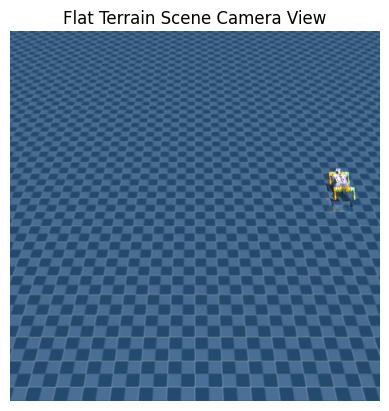

In [12]:
from custom_env import GoogleBarkourEnv
envs.register_environment('barkour', GoogleBarkourEnv)
env = envs.get_environment("barkour")

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))

img = env.render([state.pipeline_state], camera='scene', width=480, height=480)[0]
plt.imshow(img)
plt.title("Flat Terrain Scene Camera View")
plt.axis("off")
plt.show()

`TODO(student): `Impliment at least (2/5) "TODOs" in the [`terrain_generator.py`](./terrain_generator.py) file. You can use the next code blocks to generate a modified XML using the `TerrainGenerator` class. **(20 pts)**

In [16]:
# TODO: impliment the todos in the terrain_generator.py file to procedurally generate terrain
import noise
from terrain_generator_student import TerrainGenerator

input_scene_path = "./google_barkour_vb/scene_mjx.xml"
output_scene_path = "./google_barkour_vb/scene_mjx_with_terrain.xml"
tg = TerrainGenerator(input_scene_path, output_scene_path)

# Box obstacle
tg.AddBox(position=[1.5, 0.0, 0.1], euler=[0, 0, 0.0], size=[1, 1.5, 0.2])

# Geometry obstacle
# geo_type supports "plane", "sphere", "capsule", "ellipsoid", "cylinder", "box"
tg.AddGeometry(position=[1.5, 0.0, 0.25], euler=[0, 0, 0.0], size=[1.0,0.5,0.5],geo_type="cylinder")

# Slope
tg.AddBox(position=[2.0, 2.0, 0.5],
            euler=[0.0, -0.5, 0.0],
            size=[3, 1.5, 0.1])

# Stairs
tg.AddStairs(init_pos=[1.0, 4.0, 0.0], yaw=0.0)

# Rough ground
tg.AddRoughGround(init_pos=[-2.5, 5.0, 0.0],
                    euler=[0, 0, 0.0],
                    nums=[10, 8])

# # Perlin height field
# tg.AddPerlinHeighField(position=[-1.5, 4.0, 0.0], size=[2.0, 1.5])

# # Heigh field from image
# tg.AddHeighFieldFromImage(position=[-1.5, 2.0, 0.0],
#                           euler=[0, 0, -1.57],
#                           size=[2.0,2.0],
#                           input_img="./unitree_robot.jpeg",
#                           image_scale=[1.0, 1.0],
#                           output_hfield_image="unitree_hfield.png")

tg.CustomTerrain()

tg.Save()




Not Implimented: CustomTerrain


/usr/local/lib/python3.10/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


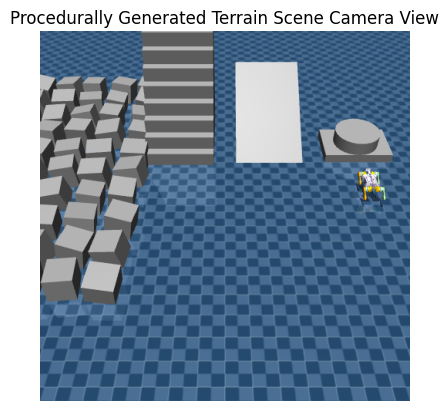

In [17]:
env = envs.get_environment("barkour", scene_file="scene_mjx_with_terrain.xml")

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))

img = env.render([state.pipeline_state], camera='scene', width=480, height=480)[0]
plt.imshow(img)
plt.title("Procedurally Generated Terrain Scene Camera View")
plt.axis("off")
plt.show()

## Generating Terrain with Contraints (Wave Function Collapse)

In this section, we'll use a cool method called Wave Function Collapse (WFC) to create custom, procedurally generated terrains for our environment! To get a high-level understanding of what this looks like, take a look at the popular git repo [https://github.com/mxgmn/WaveFunctionCollapse](https://github.com/mxgmn/WaveFunctionCollapse). 
Interestingly, one of the main use-cases for this algorithm is in computer games for self-generating maps and levels. The algorithm works by creating large output images that are "locally similar" to some small input pattern. 

![bitmap_illustration](./media/bitmap_illustration.png)

The basic implementation of the algorithm generates **bitmap images**. One idea is to use these novel, generated bitmaps to define where to place different terrain elements in the scene (i.e. boxes, walls, stairs, etc). Ideally, this procedure would help make more structured, yet random environments for the robot to explore. 

Note: there are also implementations that generate "tilemaps", however, they typically require the user to explicitly generate contraints between tiles (which is a bit too time consuming for this lab). You can read more at [https://github.com/mxgmn/WaveFunctionCollapse](https://github.com/mxgmn/WaveFunctionCollapse). 

In [ ]:
# TODO: Create your own bitmap pattern
from PIL import Image
import numpy as np

def bitmap_string_to_image(bitmap_str, output_path="bitmap_image.png"):
    lines = bitmap_str.strip().split("\n")
    height = len(lines)
    width = len(lines[0])

    # Create a numpy array
    img_array = np.zeros((height, width), dtype=np.uint8)

    # Fill array with integers
    for i, line in enumerate(lines):
        img_array[i] = [int(ch) for ch in line]

    # Define fixed color map: e.g., 0=white, 1=black, 2=red, 3=green, 4=blue
    color_palette = [
        (255, 255, 255),  # 0 - white
        (0, 0, 0),        # 1 - black
        (255, 0, 0),      # 2 - red
        (0, 255, 0),      # 3 - green
        (0, 0, 255)       # 4 - blue
    ]

    rgb_img = np.zeros((height, width, 3), dtype=np.uint8)
    unique_values = np.unique(img_array)

    for val in unique_values:
        color = color_palette[val % len(color_palette)]
        mask = img_array == val
        rgb_img[mask] = color

    # Create and save image
    img = Image.fromarray(rgb_img, "RGB")
    img.save(output_path)
    print(f"Image saved to {output_path}")
    
    return img





In [ ]:
# TODO: play around with and change this pattern! Use any integers 0-4. 
import matplotlib.pyplot as plt


bitmap_pattern_str = """
11211111111111111
11111111111111111
11000000000000011
11011111011111011
11011111011111011
11011111011111011
00011111011111000
11111110001111011
11111110001111011
11111110001111011
11110000001111011
11110000000000011
11110000001111111
11111111111121111
11111111111111111
"""

img = bitmap_string_to_image(bitmap_pattern_str, "out_bitmap.png")
plt.figure(figsize=(6,6))  # bigger display window
plt.imshow(img, cmap="gray", interpolation="nearest")
plt.title("Bitmap Pattern Image")
plt.axis("off")
plt.show()


### Generate Random Bitmaps using Your Pattern

`TODO(student):` Use the initial pattern that you just created to generate a larger output bitmap. **(40 pts)**

To do this, use [this python implimentation of the Wave Function Collapse algorithm](https://github.com/ikarth/wfc_2019f?tab=readme-ov-file). Follow along with the readme to understand how to add your own custom patterns. I've found it best to just do this task on your local computer.  

In [ ]:
# TODO: Display your full output bitmap here

### Use Your Procedurally Generated Bitmap to Influence the Mujoco Terrain

`TODO(student):` Somehow use your generated bitmap to influence the terrain in some way using the `TerrainGenerator` class you implimented in the previous section. **(40 pts)**

There are many ways to do this, here are a few ideas: 
1. come up with a mapping from pixels to world locations and spawn different terrain elements for different pixel values
2. simply interpret the bitmap image as a heightmap in the `TerrainGenerator`


In [ ]:
# TODO: Display your final mujoco scene here

This idea can actually be extended to more complicated terrains and meshes! See [the terrain-generator repository](https://github.com/leggedrobotics/terrain-generator) for a more detailed implimentation if you're curious!

## Adding a Dynamic Obstacle (Optional / No Credit)

Another thing you may be interested in is adding dynamic object to the scene that the robot can interact with. If interested, take a look at [`pick.py`](https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/manipulation/franka_emika_panda/pick.py) from the official mujoco_playground repo to figure out how to do this. 


Note that you'll have to modify both the environment file `custom_env.py` and the `google_barkour_vb/scene_mjx.xml` file to get this to work!

## What to Turn In

`#TODO(student):` Please zip the following files and turn them into the assignment on gradescope:
1. this `04_lab_student.ipynb` file. Please make sure to fill our your name and umich ID in the first cell
2. the modified `terrain_generator_student.py` file.